## 2 Recommender Systems ##

Implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.
This dataset consists of ratings on a scale of 1 to 5. 

#### 2.1 Movie ratings dataset ####

In [177]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.optimize import minimize

In [180]:
data = scipy.io.loadmat('ex8_movies.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [181]:
Y = data['Y']
R = data['R']
Y.shape # movies x users

(1682, 943)

In [182]:
Y[:3]

array([[5, 4, 0, ..., 5, 0, 0],
       [3, 0, 0, ..., 0, 0, 5],
       [4, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [183]:
R.shape

(1682, 943)

In [184]:
R[:3]

array([[1, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [185]:
print('Average rating for \'Toy Story\': %.2f' %(np.mean(Y[0, R[0, :]==1])))
np.mean(Y[0,:]) #This mean would be different because this will consider no ratings also and hence denominator would be all users including users who didnt rate.


Average rating for 'Toy Story': 3.88


1.8589607635206786

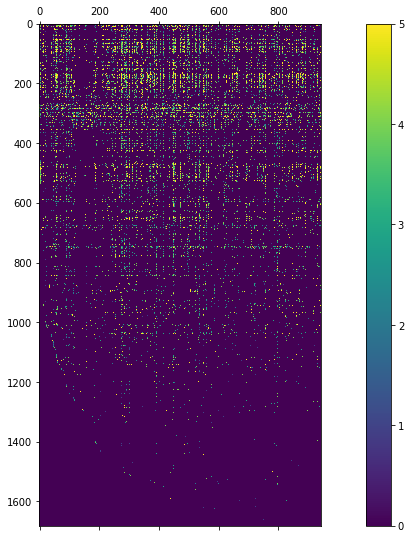

In [186]:
#Visualize movie ratings

plt.figure(figsize=(16, 9))
plt.matshow(Y, fignum=1)
plt.colorbar()
plt.show()

#### 2.2 Collaborative filtering learning algorithm ####

##### 2.2.1 Collaborative filtering cost function  and Gradient#####

In [187]:
data = scipy.io.loadmat('ex8_movieParams.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [188]:
#X is the movie feature matrix
X = data['X']
X.shape

(1682, 10)

In [189]:
#Theta is user parameters
Theta = data['Theta']
Theta.shape

(943, 10)

In [190]:
#Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3

X = X[0:num_movies, 0:num_features]
Theta = Theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]
X

array([[ 1.0486855 , -0.40023196,  1.19411945],
       [ 0.78085123, -0.38562591,  0.52119779],
       [ 0.64150886, -0.54785385, -0.08379638],
       [ 0.45361782, -0.80021844,  0.68048129],
       [ 0.93753789,  0.1060899 ,  0.36195295]])

In [191]:
def cofiCostFunc(params, Y, R, num_users, num_movies,num_features,lambda_):
    
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    #Cost without regularization
    ratings = np.dot(X, Theta.T) * R
    J = (np.sum((ratings - Y)**2))/2
    
   
    # Compute gradient without regularization
    X_grad = np.dot((ratings - Y), Theta)
    Theta_grad = np.dot((ratings - Y).T, X)
    
    #Regularization
    Theta_reg_term = (lambda_/2) * (np.sum(Theta**2))
    X_reg_term = (lambda_/2) * ((np.sum(X**2)))
    
    J = J + Theta_reg_term + X_reg_term
    
    X_grad = X_grad + (lambda_ * X)
    Theta_grad = Theta_grad + (lambda_ * Theta)
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    
    

    return J, grad
    
    

In [192]:
J, grad = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),Y, R, num_users, num_movies,num_features,0)
print("The cost should be around 22.22, value after running cofiCostFunc without Reg - ", J)

J, grad = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),Y, R, num_users, num_movies,num_features,1.5)
print("The cost should be around 31.34, value after running cofiCostFunc without Reg - ", J)

The cost should be around 22.22, value after running cofiCostFunc without Reg -  22.224603725685675
The cost should be around 31.34, value after running cofiCostFunc without Reg -  31.34405624427422


In [193]:
#Check the gradient Function numerically - The below two functions are for that.

def computeNumericalGradient(coficost, params):
    
    numgrad = np.zeros(params.shape)
    perturb = np.zeros(params.shape)
    
    e = 1e-4
      
    for p in range(params.size):
        #Set perturbation vector
        perturb[p] = e

        p1 = params - perturb
        p2 = params + perturb
        
        
        loss1 = coficost(p1)[0]
        loss2 = coficost(p2)[0]
        
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
    
    return numgrad
        


In [194]:
def checkCostFunction(lambda_=0):
    
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)
    
    #Zap out most entries
    Y = np.dot(X_t , Theta_t.T)
    Y[np.random.rand(*Y.shape) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1
    
    # Run Gradient Checking
    #https://stackoverflow.com/questions/12555627/python-3-starred-expression-to-unpack-a-list
    X = np.random.randn(*X_t.shape)
    Theta = np.random.randn(*Theta_t.shape)
    
        
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    num_features = Theta_t.shape[1]
    params_test = np.concatenate([X.ravel(), Theta.ravel()])
    
    def coficost(params_test):
        return cofiCostFunc(params_test, Y, R, num_users, num_movies, num_features, lambda_)
                             
    # Analytical gradient
    J, angrad = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),Y, R, num_users, num_movies,num_features,0)
    
    # Numerical gradient
    numgrad = computeNumericalGradient(coficost, np.concatenate([X.ravel(), Theta.ravel()]))
    
#Note for self  - See how coficostfn is called, the above code works similar.    
#     numgrad = np.zeros(params_test.shape)
#     perturb = np.zeros(params_test.shape)
    
#     e = 1e-4
      
#     for p in range(params_test.size):
#         #Set perturbation vector
#         perturb[p] = e

#         p1 = params_test - perturb
#         p2 = params_test + perturb
        
        
#         loss1 = cofiCostFunc(p1, Y, R, num_users, num_movies, num_features, lambda_)[0]
#         loss2 = cofiCostFunc(p2, Y, R, num_users, num_movies, num_features, lambda_)[0]
        
#         numgrad[p] = (loss2 - loss1) / (2*e)
#         perturb[p] = 0
    
    diffgrad = angrad - numgrad
    
    print(np.stack([numgrad, angrad, diffgrad], axis=1))
    print('\nThe first two columns you get should be very similar and the third is diff'
          '(from Left to Right - Numerical Gradient, Analytical Gradient, difference)')
 
    

In [195]:
checkCostFunction()

[[-2.12679849e+01 -2.12679849e+01  2.07336370e-11]
 [ 1.15649598e-01  1.15649598e-01  1.64018799e-12]
 [ 2.20688350e+01  2.20688350e+01  3.64863695e-12]
 [ 1.33479281e+00  1.33479281e+00 -1.03319575e-11]
 [ 1.64227657e-02  1.64227657e-02 -1.68699985e-11]
 [-7.50023490e-02 -7.50023490e-02 -5.73187331e-12]
 [-6.20961960e-01 -6.20961960e-01 -6.84252655e-12]
 [ 1.39899544e-01  1.39899544e-01  8.47422132e-12]
 [ 8.86905491e-01  8.86905491e-01  1.63852265e-11]
 [ 5.29430469e+00  5.29430469e+00 -2.18847163e-12]
 [ 5.10422300e-01  5.10422300e-01  1.43892676e-11]
 [-4.08113313e+00 -4.08113313e+00 -6.64179822e-12]
 [-6.68001905e+00 -6.68001905e+00  4.94093655e-12]
 [ 2.65503828e+00  2.65503828e+00  1.30770950e-11]
 [ 2.46634943e+00  2.46634943e+00  1.33502098e-11]
 [ 1.38789635e+00  1.38789635e+00  4.05653289e-12]
 [-6.70201809e-01 -6.70201809e-01 -8.36331004e-12]
 [-7.57022197e-01 -7.57022196e-01  4.86510832e-12]
 [ 5.68691787e+00  5.68691787e+00  9.82502968e-12]
 [-2.97071730e+00 -2.97071730e+

In [196]:
#self note - just a cell to explain how starred expression works in Python
t = np.random.rand(4, 3)


print(*t.shape)
print(t.shape)
test =np.random.rand(*t.shape)
test

4 3
(4, 3)


array([[0.52116615, 0.41884273, 0.62347265],
       [0.42136544, 0.59879466, 0.47385425],
       [0.35303672, 0.82937832, 0.12753094],
       [0.22714198, 0.66213394, 0.2428273 ]])

#### 2.3 Learning movie recommendations ####

After you have finished implementing the collaborative filtering cost function
and gradient, you can now start training your algorithm to make movie recommendations for yourself.

In [225]:
def loadmovieList():
    
    file = open('movie_ids.txt', encoding='ISO-8859-1')
    movie_ids = file.read().splitlines()
    file.close()
    return movie_ids
    

In [234]:
movie_ids = loadmovieList()
movie_ids
len(movie_ids)

1682

In [199]:
n = len(movie_ids)

#  Initialize my ratings
my_ratings = np.zeros([n, 1])

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5



In [200]:
#https://stackoverflow.com/questions/9989334/create-nice-column-output-in-python/9996049#9996049
print("{: <50} {: <6}".format('Movie', 'Rating'))
for i in range (n):
    if my_ratings[i] > 0:
        print("{: <50} {: >6}".format(movie_ids[i], int(my_ratings[i])))

Movie                                              Rating
1 Toy Story (1995)                                      4
7 Twelve Monkeys (1995)                                 3
12 Usual Suspects, The (1995)                           5
54 Outbreak (1995)                                      4
64 Shawshank Redemption, The (1994)                     5
66 While You Were Sleeping (1995)                       3
69 Forrest Gump (1994)                                  5
98 Silence of the Lambs, The (1991)                     2
183 Alien (1979)                                        4
226 Die Hard 2 (1990)                                   5
355 Sphere (1998)                                       5


In [201]:
#================== Part 7: Learning Movie Ratings ====================
#Now, you will train the collaborative filtering model on a movie rating 
#  dataset of 1682 movies and 943 users
#You will concatenate my_ratings to the data given and predict other ratings.

data = scipy.io.loadmat('ex8_movies.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [202]:
Y = data['Y']
R = data['R']

R_my_ratings = np.zeros(my_ratings.shape)

#Add our own ratings to the data matrix
R_my_ratings[my_ratings != 0] = 1

#append R_my_ratings to create new R
R = np.append(R, R_my_ratings, axis=1)

#Add my_ratings to Y to create new Y
Y = np.append(Y, my_ratings, axis=1)

In [203]:
def normalizeRatings(Y, R):
    m, n = Y.shape
    Ymean = np.zeros([m,1])
    Ynorm = np.zeros([m,n])
    for i in range(m):
        idx = np.where(R[i, :] == 1)
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    return Ynorm, Ymean

In [204]:
Ynorm, Ymean = normalizeRatings(Y, R)
Ymean
Ynorm
Y

array([[5., 4., 0., ..., 0., 0., 4.],
       [3., 0., 0., ..., 0., 5., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [205]:
#Useful Values
num_movies, num_users = Y.shape
num_features = 10

In [206]:
#Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

#set regularization
lambda_ = 10


def cost_func(params):
    return cofiCostFunc(params, Ynorm, R, num_users, num_movies, num_features, lambda_)

result = minimize(fun=cost_func, x0=initial_parameters, method='CG', jac=True, options={'maxiter':100})

minimized_paramters = result.x

X = minimized_paramters[:num_movies*num_features].reshape(num_movies, num_features)
Theta = minimized_paramters[num_movies*num_features:].reshape(num_users, num_features)




In [207]:
result

     fun: 38957.6893626532
     jac: array([-0.08294241,  0.01312626,  0.08676375, ..., -0.00347835,
       -0.00355039, -0.00216991])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 150
     nit: 100
    njev: 150
  status: 1
 success: False
       x: array([-0.43391726,  0.14215633,  0.24063267, ..., -0.07888234,
       -0.01474771,  0.09048345])

**Part 8: Recommendation for you**

After training the model, you can now make recommendations by computing the predictions matrix.

In [248]:
p = np.dot(X, Theta.T)
my_predictions = np.reshape(p[:, -1], (m, 1))
my_predictions += Ymean

ix = (my_predictions).argsort(axis=0)[::-1]

#ix = np.argsort(my_predictions[::-1], axis=0)


print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = int(ix[i])
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movie_ids[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movie_ids[i]))

Top recommendations for you:
----------------------------
Predicting rating 5.0 for movie 1189 Prefontaine (1997)
Predicting rating 5.0 for movie 1500 Santa with Muscles (1996)
Predicting rating 5.0 for movie 1122 They Made Me a Criminal (1939)
Predicting rating 5.0 for movie 1201 Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0 for movie 1293 Star Kid (1997)
Predicting rating 5.0 for movie 1599 Someone Else's America (1995)
Predicting rating 5.0 for movie 1467 Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie 1536 Aiqing wansui (1994)
Predicting rating 5.0 for movie 1653 Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie 814 Great Day in Harlem, A (1994)

Original ratings provided:
--------------------------
Rated 4 for 1 Toy Story (1995)
Rated 3 for 7 Twelve Monkeys (1995)
Rated 5 for 12 Usual Suspects, The (1995)
Rated 4 for 54 Outbreak (1995)
Rated 5 for 64 Shawshank Redemption, The (1994)
Rated 3 for 66 While You We